In [1]:
from maelstrom.maelstrom import kepler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import tensorflow as tf

/Users/danielhey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
kicid=9651065
times, mags = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid


nu_data = [19.47767438, 21.71213375, 30.80189732, 17.69941551, 22.69429318,16.26846361, 13.62339726, 36.14642035]
nu_data = [19.47767438]

In [3]:
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orb_params = orbits[orbits.Name == f"kic{kicid}"].iloc[0]

porb_t = orb_params.Porb
a1_t = orb_params["a1sini/c"]
tp_t = orb_params["t_p"] - 0
e_t = orb_params["e"]
varpi_t = orb_params["varpi"]
e_param_t = np.log(e_t) - np.log(1.0 - e_t)

In [11]:
orb_params

Name                   kic9651065
Porb                      272.425
Porb_sig_p               0.296224
Porb_sig_m               0.301695
a1sini/c                  184.557
a1sini/c_sig_p            2.47593
a1sini/c_sig_m            2.56325
e                        0.466711
e_sig_p                  0.021416
e_sig_m                  0.021006
phip                     0.623749
phip_sig_p               0.006471
phip_sig_m               0.006454
varpi                     2.19866
varpi_sig_p              0.042901
varpi_sig_m               0.04211
f(M)Msun                0.0909446
f(M)Msun_sig_p          0.0036658
f(M)Msun_sig_m          0.0037945
gradient                -0.023354
grad_sig_p                0.00303
grad_sig_m               0.003051
t_p                       55128.3
t_p_sig_p                 1.78803
t_p_sig_m                 1.78347
K1_ms                     13063.5
K1_ms_sig_p                 206.9
K1_ms_sig_m                 195.9
median_segment_size           NaN
Name: 290, dty

In [4]:
# The default type in tensorflow is float32, but we want to force float64 here.
T = tf.float64

session = tf.InteractiveSession()

# Convert the numpy arrays to tensors.
time = tf.constant(times, dtype=T)
mag = tf.constant(mags, dtype=T)

In [5]:
def get_bounded_for_value(value, min_value, max_value):
    if np.any(value <= min_value) or np.any(value >= max_value):
        raise ValueError("value must be in the range (min_value,\
         max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_bounded(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, 
                        dtype=tf.float64):
    param = tf.Variable(get_bounded_for_value(value, min_value, 
                        max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = (tf.log(var - min_value) + tf.log(max_value - var) -
                    np.log(max_value - min_value))
    return param, var, tf.reduce_sum(log_jacobian), (min_value, max_value)

In [12]:
# Parameters
T = tf.float64
period = tf.Variable(272.0, dtype=T, name="period")
lighttime = tf.Variable(np.zeros_like(nu_data), dtype=T, name="lighttime")
lighttime_inds = tf.Variable(
    np.arange(len(nu_data)).astype(np.int32), dtype=tf.int32,
    name="lighttime_inds")
tref = tf.Variable(0.0, dtype=T, name="tref")
eccen_param = tf.Variable(-5.0, dtype=T, name="eccen_param")
varpi = tf.Variable(2., dtype=T, name="varpi")
eccen = 1.0 / (1.0 + tf.exp(-eccen_param))

# Which parameters do we fit for?
params = [period, lighttime, tref, eccen_param, varpi]

# Set up the model
mean_anom = 2.0*np.pi*(time-tref)/period

ecc_anom = kepler(mean_anom, eccen)
true_anom = 2.0*tf.atan2(
    tf.sqrt(1.0+eccen) * tf.tan(0.5*ecc_anom),
    tf.sqrt(1.0-eccen) + tf.zeros_like(time))
factor = 1.0 - tf.square(eccen)
factor /= 1.0 + eccen*tf.cos(true_anom)
psi = -factor * tf.sin(true_anom + varpi)

# Build the design matrix
_lighttime_per_mode = tf.gather(lighttime,
                                     lighttime_inds)
tau = _lighttime_per_mode[None, :] * psi[:, None]

In [13]:
nu = tf.Variable(nu_data, dtype=T, name="frequencies")

arg = 2.0*np.pi*nu[None, :] * (time[:, None] - tau)
D = tf.concat([tf.cos(arg), tf.sin(arg)],
              axis=1)

# Solve for the amplitudes and phases of the oscillations
DTD = tf.matmul(D, D, transpose_a=True)
DTy = tf.matmul(D, mag[:, None], transpose_a=True)
W_hat = tf.linalg.solve(DTD, DTy)

# Model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D, W_hat))
chi2 = tf.reduce_sum(tf.square(mag - model_tensor))
#self.chi2 *= tf.exp(-log_sigma2)
#self.chi2 += len(time_data) * self.log_sigma2
log_like = - 0.5 * chi2

In [14]:
session.run(tf.global_variables_initializer())

In [15]:
fit_params = [period, lighttime, tref, eccen_param, varpi]


Initial log likelihood: -0.08701715420782932
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.085431
  Number of iterations: 16
  Number of functions evaluations: 24
Final log likelihood: -0.08543130517453643

Final parameters: [271.9977970621495, array([0.00185962]), -0.0036185364151933947, -4.999271135927762, 2.1565798025178236]


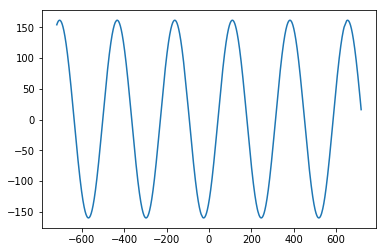

In [16]:
neg_log_like = -log_like

opt = tf.contrib.opt.ScipyOptimizerInterface(
    neg_log_like, var_list=fit_params)

session.run(tf.global_variables_initializer())

print("Initial log likelihood: {0}".format(session.run(log_like)))
opt.minimize(session)
print("Final log likelihood: {0}\n".format(session.run(log_like)))

params = session.run(fit_params)
print("Final parameters: {0}".format(params))

a = session.run(tau)

plt.plot(times,a*86400)
#plt.plot(times,)

In [17]:
class TFModel(object):

    def __init__(self, target, var_list, feed_dict=None, session=None):
        self.target = target
        self.var_list = var_list
        self.grad_target = tf.gradients(self.target, self.var_list)
        self.feed_dict = {} if feed_dict is None else feed_dict
        self._session = session

    @property
    def session(self):
        if self._session is None:
            return tf.get_default_session()
        return self._session

    def value(self, vector):
        feed_dict = self.vector_to_feed_dict(vector)
        return self.session.run(self.target, feed_dict=feed_dict)

    def gradient(self, vector):
        feed_dict = self.vector_to_feed_dict(vector)
        return np.concatenate([
            np.reshape(g, s) for s, g in zip(
                self.sizes,
                self.session.run(self.grad_target, feed_dict=feed_dict))
        ])

    def setup(self, session=None):
        if session is not None:
            self._session = session
        values = self.session.run(self.var_list)
        self.sizes = [np.size(v) for v in values]
        self.shapes = [np.shape(v) for v in values]

    def vector_to_feed_dict(self, vector):
        i = 0
        fd = dict(self.feed_dict)
        for var, size, shape in zip(self.var_list, self.sizes, self.shapes):
            fd[var] = np.reshape(vector[i:i+size], shape)
            i += size
        return fd

    def feed_dict_to_vector(self, feed_dict):
        return np.concatenate([
            np.reshape(feed_dict[v], s)
            for v, s in zip(self.var_list, self.sizes)])

    def current_vector(self):
        values = self.session.run(self.var_list)
        return np.concatenate([
            np.reshape(v, s)
            for v, s in zip(values, self.sizes)])

In [18]:
log_prob = log_like

model = TFModel(log_prob, fit_params)
    
# Within the session, you first need to call the `setup` method.
model.setup(session)
params = model.current_vector()

# The value and gradient of the tensor can be evaluated for specific
# values of the parameters.
print("The value is: {0}".format(model.value(params)))

The value is: -0.08543130517453643


In [19]:
import time
import emcee

emcee_time = time.time()
#session.run(tf.global_variables_initializer())
model.setup(session)

pos = model.current_vector()
pos = pos + 1e-3*np.random.randn(100, len(pos))
nwalkers, ndim = pos.shape



In [20]:
model.current_vector()

array([ 2.71997797e+02,  1.85962002e-03, -3.61853642e-03, -4.99927114e+00,
        2.15657980e+00])

In [21]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.value)
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()
pos, _, _ = sampler.run_mcmc(pos, 1000)
emcee_time = time.time() - emcee_time

emcee: Exception while calling your likelihood function:
  params: [251.43174606  40.20164503  14.63438864  47.76281226  74.51849174]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1334, in _do_call
    return fn(*args)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1319, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1407, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Input matrix is not invertible.
	 [[{{node MatrixSolve_1}} = MatrixSolve[T=DT_DOUBLE, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](MatMul_3, MatMul_4)]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.arg

InvalidArgumentError: Input matrix is not invertible.
	 [[node MatrixSolve_1 (defined at <ipython-input-13-d7da74626328>:10)  = MatrixSolve[T=DT_DOUBLE, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](MatMul_3, MatMul_4)]]

Caused by op 'MatrixSolve_1', defined at:
  File "/Users/danielhey/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/danielhey/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/danielhey/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/danielhey/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/danielhey/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-d7da74626328>", line 10, in <module>
    W_hat = tf.linalg.solve(DTD, DTy)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 1190, in matrix_solve
    "MatrixSolve", matrix=matrix, rhs=rhs, adjoint=adjoint, name=name)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Users/danielhey/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input matrix is not invertible.
	 [[node MatrixSolve_1 (defined at <ipython-input-13-d7da74626328>:10)  = MatrixSolve[T=DT_DOUBLE, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](MatMul_3, MatMul_4)]]
